### Chuẩn bị data

```text
datasets/
├── BEAT/
│   ├── 1/
│   ├── 2/
|   ├── ...
|   └── ...
├── BEAT_numpy/
│   ├── npy/
│   └── txt/
```

In [2]:
base_dir = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT"
out_dir = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT_numpy"

### Tính mean/std cho toàn bộ dataset

In [ ]:
# !python "/home/serverai/ltdoanh/Motion_Diffusion/datasets/step1_fit_scaler.py" --parent-dir "{base_dir}" --start 1 --end 30 --mode hybrid

### Chuyển dataset bvh sang npy theo từng segment

In [ ]:
# import os
# for i in range(6, 31):
#     print("Đang chạy preprocess_data.py...")
#     command2 = f'python "/home/serverai/ltdoanh/Motion_Diffusion/datasets/preprocess_data.py" --parent-dir "{base_dir}" --out-root "{out_dir}" --folders "{i}"'
#     os.system(command2)

In [ ]:
# !python "/home/serverai/ltdoanh/Motion_Diffusion/datasets/preprocess_data.py" --parent-dir "{base_dir}" --out-root "{out_dir}" --folders "5"

In [ ]:
# from textgrid import TextGrid

# tg = TextGrid.fromFile("/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/5/5_stewart_0_82_82.TextGrid")
# print(f"Number of tiers: {len(tg)}")
# for i, tier in enumerate(tg):
#     print(f"Tier {i}: {tier.name}, intervals: {len(tier.intervals)}")

### Train MotionDiffuse như bình thường

In [ ]:
!python "/home/serverai/ltdoanh/Motion_Diffusion/tools/train.py" --dataset_name beat

### Train VQ-VAE

In [8]:
!python tools/train_vq_with_attention.py \
    --name VQKL_Attention_BEAT \
    --batch_size 64 \
    --max_epoch 30 \
    --use_attention \
    --encoder_attention_layers 2 \
    --use_skip_connections \
    --skip_connection_type concat \
    --gpu_id 0


VQ-VAE WITH SELF-ATTENTION AND SKIP CONNECTIONS
Device: cuda:0
Architecture: VQ + KL + Attention + Skip Connections
Dataset: BEAT

[INFO] Checkpoints: ./checkpoints/beat/VQKL_Attention_BEAT
[INFO] Loading stats from /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
[INFO] ✓ Stats loaded
[INFO] ./datasets/BEAT_numpy/train.txt already exists
[INFO] ./datasets/BEAT_numpy/val.txt already exists

[INFO] Setting up dataloaders...
Loading motion‑text pairs: 100%|██████████████| 847/847 [00:15<00:00, 54.74it/s]
[INFO] ✓ Train: 7627 samples
[INFO] ✓ Val: 847 samples

[INFO] Initializing VQ-VAE with Attention...
[INFO] Architecture:
  - Input dim: 264
  - Codebook size: 1024
  - Codebook dim: 512
  - Embed dim (KL): 512
  - Num quantizers: 10

[INFO] Attention:
  - Enabled: True
  - Type: self
  - Num heads: 8
  - Encoder layers: [2]
  - Decoder layers: [1]

[INFO] Skip Connections:
  - Enabled: True
  - Type: concat

[INFO] Loss weights:
  - Reconstruction: 1.0 (l1)
  - Velocity: 0.1

In [ ]:
!python tools/train_vq.py \
    --name VQKL_BEAT \
    --double_z \
    --embed_dim 512 \
    --kl_weight 1e-6 \
    --use_posterior_sample \
    --max_epoch 25 \
    --batch_size 64

In [16]:
!python ./tools/train_vq_with_discriminator.py \
    --name VQKL_GAN_BEAT \
    --batch_size 32 \
    --max_epoch 50 \
    --disc_start 10000 \
    --disc_weight 0.75 \
    --perceptual_weight 0.1 \
    --kl_weight 1e-6


VQ-KL + GAN + PERCEPTUAL LOSS TRAINING
Device: cuda:0
Architecture: VQ + KL + LPIPS + Discriminator
Dataset: BEAT

[INFO] Loading stats from /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
[INFO] ✓ Stats loaded
[INFO] ./datasets/BEAT_numpy/train.txt already exists
[INFO] ./datasets/BEAT_numpy/val.txt already exists

[INFO] Setting up dataloaders...
Loading motion‑text pairs: 100%|██████████████| 847/847 [00:15<00:00, 53.62it/s]
[INFO] ✓ Train: 7627 samples
[INFO] ✓ Val: 847 samples

[INFO] Initializing VQ-KL + GAN Model...
[INFO] Architecture:
  - VQ codebook size: 1024
  - VQ codebook dim: 512
  - KL embed dim: 512
  - Num quantizers: 10
  - Discriminator starts at iter: 10000

[INFO] Loss weights:
  - Reconstruction: 1.0 (l1)
  - Velocity: 0.1
  - VQ Commitment: 0.02
  - KL: 1e-06
  - Discriminator: 0.75
  - Perceptual (LPIPS): 0.1

[INFO] ✓ Model: 28.36M parameters

[INFO] Initializing Trainer with GAN...

[INFO] Trainer Configuration:
  - VQ-KL mode: True
    • KL weig

In [9]:
!python ./tools/scale_factor.py --vqvae_name VQKL_Attention_BEAT

Loading VQ-KL model...

INITIALIZING ENHANCED VQ-VAE WITH ATTENTION
[INFO] Added self attention at encoder layer 2
[INFO] EncoderWithAttention initialized:
  - Input: 264 dims
  - Output: 512 dims
  - Down-sampling stages: 3
  - Attention: self
  - Skip connections: True
[INFO] Added self attention at decoder layer 1
[INFO] DecoderWithAttention initialized:
  - Input: 512 dims
  - Output: 264 dims
  - Up-sampling stages: 3
  - Attention: self
  - Skip connections: True (concat)
[INFO] KL divergence enabled (double_z=True)

Loading checkpoint from ./checkpoints/beat/VQKL_Attention_BEAT/model/best_model.tar
Loading dataset...
Loading motion‑text pairs: 100%|███████████| 7627/7627 [01:02<00:00, 121.48it/s]
Processing 7627 samples...
100%|█████████████████████████████████████████| 239/239 [00:08<00:00, 28.96it/s]
Collected latents shape: (7627, 45, 512)

VQ-KL LATENT SPACE STATISTICS
Mean:  0.001175
Std:   0.608849
Min:   -3.700114
Max:   3.723996
Range: [-3.700114, 3.723996]

Recommended 

### Train MotionDiffuse trên Latent Space do VQ-VAE ở trên

In [ ]:
# !python "/home/serverai/ltdoanh/Motion_Diffusion/tools/train_vq_diffusion.py" --dataset_name beat --vqvae_name VQVAE_BEAT --sampler ddim --max_epoch 200

In [ ]:
!python tools/train_vq_diffusion.py \
    --name vqkl_diffusion \
    --vqkl_name VQKL_BEAT \
    --use_kl_posterior

### Evaluation - Đang fix lỗi ...

In [ ]:
# !python "/home/serverai/ltdoanh/Motion_Diffusion/run_evaluation.py"

### Visual data bằng mean/std chuẩn tính từ bộ dữ liệu

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
import numpy as np
import joblib

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

print("✅ Imports successful!")

# ===== CELL 2: Load Pipeline =====
pipeline_path = "/home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl"

print(f"📦 Loading pipeline from: {pipeline_path}")

pipeline = joblib.load(pipeline_path)
print(f"✅ Pipeline loaded!")
print(f"   Mean shape: {pipeline.named_steps['stdscale'].data_mean_.shape}, First 5 values: {pipeline.named_steps['stdscale'].data_mean_[:5]}")
print(f"   Std shape: {pipeline.named_steps['stdscale'].data_std_.shape},  First 5 values: {pipeline.named_steps['stdscale'].data_std_[:5]}")

# ===== CELL 3: Load and Visualize Motion =====
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/motion.npy"
frame = 50

print(f"\n🎬 Visualizing: {os.path.basename(npy_path)}")
print(f"   Frame: {frame}")

# Load motion data
motion_data = np.load(npy_path)
print(f"   Motion shape: {motion_data.shape}")

# Inverse transform
print("   Performing inverse transform...")
reconstructed = pipeline.inverse_transform([motion_data])
print(f"   ✅ Reconstructed shape: {reconstructed[0].values.shape}")

# Visualize 2D
print("\n   Creating 2D visualization...")
fig1 = plt.figure(figsize=(10, 8))
draw_stickfigure(reconstructed[0], frame=frame)
plt.title(f"2D Stick Figure - Frame {frame}")
plt.tight_layout()
plt.show()

print("   ✅ 2D plot displayed!")

# Visualize 3D
print("\n   Creating 3D visualization...")
fig2 = plt.figure(figsize=(10, 8))
draw_stickfigure3d(reconstructed[0], frame=frame)
plt.title(f"3D Stick Figure - Frame {frame}")
plt.tight_layout()
plt.show()

print("   ✅ 3D plot displayed!")

### Visual data bằng mean/std từ model được huấn luyện - Latent MotionDiffuse

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import torch

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline

print("✅ Imports successful!")

# ===== CREATE PIPELINE WITH META =====
print("\n🔨 Creating pipeline from scratch...")

# 1. Create empty pipeline
pipeline = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

# 2. Fit pipeline on sample BVH (to learn structure)
bvh_sample_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/1/1_wayne_0_1_1.bvh"
print(f"   Fitting on BVH sample: {os.path.basename(bvh_sample_path)}")

parser = BVHParser()
parsed_data = parser.parse(bvh_sample_path)
pipeline.fit([parsed_data])
print("   ✅ Pipeline fitted (structure learned)")

# 3. Load mean/std from meta directory
# meta_dir = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/meta"
# mean_path = os.path.join(meta_dir, "mean.npy")
# std_path = os.path.join(meta_dir, "std.npy")
ckpt_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/vq_diffusion/model/latest.pt"  # Thay đường dẫn file của bạn vào đây

try:
    # 2. Load checkpoint
    # map_location='cpu' giúp tránh lỗi nếu máy bạn không có GPU giống lúc train
    checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)

    # 3. Kiểm tra và lấy mean, std
    if 'mean' in checkpoint and 'std' in checkpoint:
        mean = checkpoint['mean']
        std = checkpoint['std']

        print("--- Đã tìm thấy Mean và Std ---")
        print(f"Shape của Mean: {mean.shape}")
        print(f"Shape của Std: {std.shape}")
        
        # In thử vài giá trị đầu
        print(f"Mean (5 giá trị đầu): {mean[:5]}")
        print(f"Std (5 giá trị đầu): {std[:5]}")
        
        # 4. (Tùy chọn) Lưu lại ra file .npy để dùng việc khác nếu cần
        # np.save('mean.npy', mean)
        # np.save('std.npy', std)
        # print("Đã lưu ra file .npy")
        
    else:
        print("Không tìm thấy key 'mean' hoặc 'std' trong file .pt này.")
        print("Các keys hiện có:", checkpoint.keys())

except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

# 4. Override pipeline's mean/std with meta values
print("\n🔧 Overriding pipeline statistics with meta values...")
pipeline.named_steps['stdscale'].data_mean_ = mean
pipeline.named_steps['stdscale'].data_std_ = std
print("   ✅ Pipeline updated with meta statistics!")

# ===== VISUALIZE MOTION =====
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT_numpy/npy/2/2_scott_0_2_2_sentence_000.npy"
frame = 50

print(f"\n🎬 Visualizing: {os.path.basename(npy_path)}")
print(f"   Frame: {frame}")

# Load motion data
motion_data = np.load(npy_path)
print(f"   Motion shape: {motion_data.shape}")

# Inverse transform
print("   Performing inverse transform...")
reconstructed = pipeline.inverse_transform([motion_data])
print(f"   ✅ Reconstructed shape: {reconstructed[0].values.shape}")

# Visualize 2D
print("\n   Creating 2D visualization...")
fig1 = plt.figure(figsize=(10, 8))
draw_stickfigure(reconstructed[0], frame=frame)
plt.title(f"2D Stick Figure (Meta) - Frame {frame}")
plt.tight_layout()
plt.show()

print("   ✅ 2D plot displayed!")

# Visualize 3D
print("\n   Creating 3D visualization...")
fig2 = plt.figure(figsize=(10, 8))
draw_stickfigure3d(reconstructed[0], frame=frame)
plt.title(f"3D Stick Figure (Meta) - Frame {frame}")
plt.tight_layout()
plt.show()

print("   ✅ 3D plot displayed!")

### Visual data bằng mean/std từ model được huấn luyện - MotionDiffuse

✅ Imports successful!

🔨 Creating pipeline from scratch...
   Fitting on BVH sample: 1_wayne_0_1_1.bvh
   ✅ Pipeline fitted (structure learned)

📥 Loading Mean/Std from Meta files...
   ✅ Đã tìm thấy Mean và Std từ file .npy
   Shape của Mean: (264,)
   Shape của Std: (264,)
   Mean (5 giá trị đầu): [0.01007969 0.00226879 0.01035749 0.01484728 0.00253134]

🔧 Overriding pipeline statistics with meta values...
   ✅ Pipeline updated with meta statistics!

🎬 Visualizing: motion.npy
   Motion shape: (360, 264)
   Performing inverse transform...
positions 2 eulers is not supported
   ✅ Reconstructed shape: (360, 264)

   Creating 2D visualization...


<Figure size 1000x800 with 0 Axes>

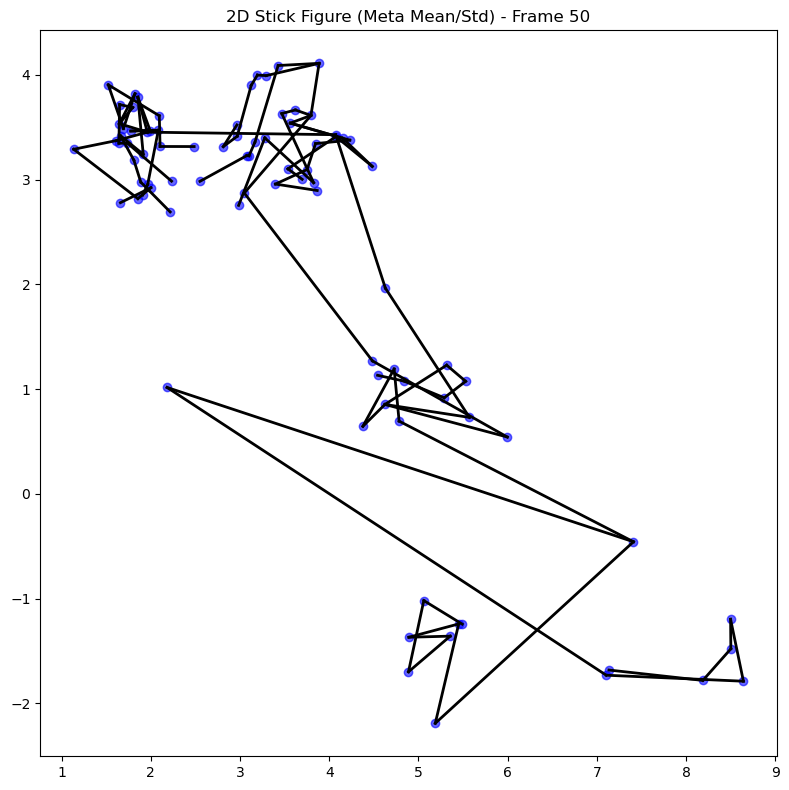


   Creating 3D visualization...


<Figure size 1000x800 with 0 Axes>

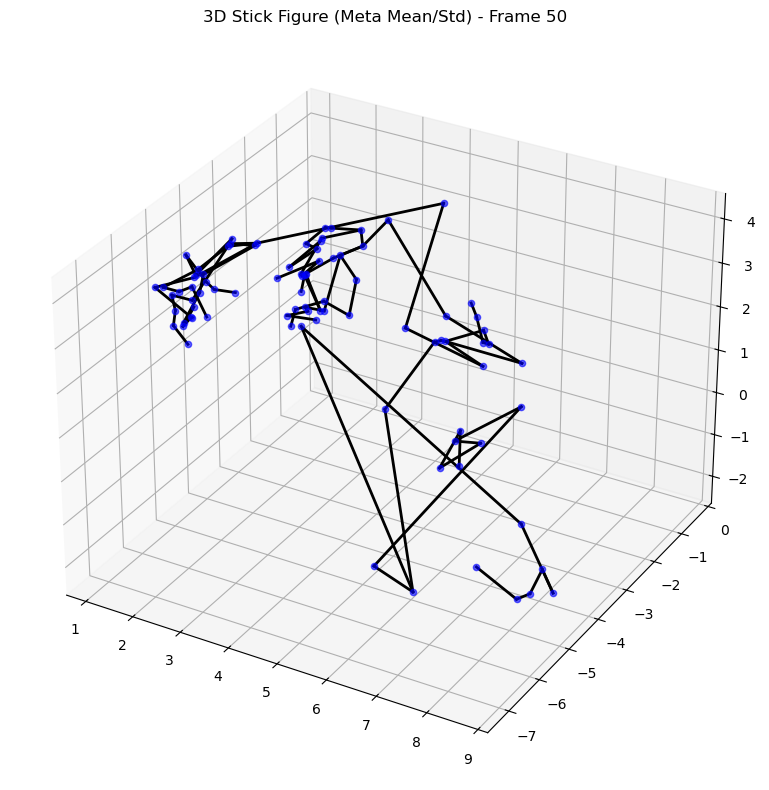

   ✅ Done!


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import torch

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline

print("✅ Imports successful!")

# ===== 1. CREATE PIPELINE WITH META =====
print("\n🔨 Creating pipeline from scratch...")

pipeline = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

# ===== 2. FIT PIPELINE (Structure Learning) =====
# Cần fit vào một file BVH mẫu để pipeline học được cấu trúc xương (skeleton)
bvh_sample_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/1/1_wayne_0_1_1.bvh"
print(f"   Fitting on BVH sample: {os.path.basename(bvh_sample_path)}")

if os.path.exists(bvh_sample_path):
    parser = BVHParser()
    parsed_data = parser.parse(bvh_sample_path)
    pipeline.fit([parsed_data])
    print("   ✅ Pipeline fitted (structure learned)")
else:
    print(f"❌ Error: BVH file not found at {bvh_sample_path}")
    sys.exit(1)

# ===== 3. LOAD MEAN/STD FROM META (.npy files) =====
meta_dir = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/meta"
mean_path = os.path.join(meta_dir, "mean.npy")
std_path = os.path.join(meta_dir, "std.npy")

print("\n📥 Loading Mean/Std from Meta files...")
try:
    # Load trực tiếp từ file .npy
    mean = np.load(mean_path)
    std = np.load(std_path)

    print("   ✅ Đã tìm thấy Mean và Std từ file .npy")
    print(f"   Shape của Mean: {mean.shape}")
    print(f"   Shape của Std: {std.shape}")
    
    # In thử vài giá trị đầu để kiểm tra
    print(f"   Mean (5 giá trị đầu): {mean[:5]}")
    
    # Override pipeline statistics
    print("\n🔧 Overriding pipeline statistics with meta values...")
    pipeline.named_steps['stdscale'].data_mean_ = mean
    pipeline.named_steps['stdscale'].data_std_ = std
    print("   ✅ Pipeline updated with meta statistics!")

except Exception as e:
    print(f"❌ Có lỗi xảy ra khi load meta: {e}")
    # Nếu không có mean/std thì visualization sẽ bị sai, nên dừng hoặc cảnh báo
    sys.exit(1)

# ===== 4. VISUALIZE MOTION =====
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/motion.npy"
frame = 50

print(f"\n🎬 Visualizing: {os.path.basename(npy_path)}")

if os.path.exists(npy_path):
    # Load motion data
    motion_data = np.load(npy_path)
    print(f"   Motion shape: {motion_data.shape}")

    # Inverse transform
    print("   Performing inverse transform...")
    # Lưu ý: inverse_transform trả về list các object MocapData
    reconstructed = pipeline.inverse_transform([motion_data])
    print(f"   ✅ Reconstructed shape: {reconstructed[0].values.shape}")

    # Visualize 2D
    print("\n   Creating 2D visualization...")
    fig1 = plt.figure(figsize=(10, 8))
    draw_stickfigure(reconstructed[0], frame=frame)
    plt.title(f"2D Stick Figure (Meta Mean/Std) - Frame {frame}")
    plt.tight_layout()
    plt.show()

    # Visualize 3D
    print("\n   Creating 3D visualization...")
    fig2 = plt.figure(figsize=(10, 8))
    draw_stickfigure3d(reconstructed[0], frame=frame)
    plt.title(f"3D Stick Figure (Meta Mean/Std) - Frame {frame}")
    plt.tight_layout()
    plt.show()
    
    print("   ✅ Done!")
else:
    print(f"❌ Error: Motion file not found at {npy_path}")

### Inference 

In [ ]:
import torch
import numpy as np
import os
import sys

from models import MotionTransformer
from trainers import DDPMTrainer
from models.vq.model import RVQVAE 

# ==========================================
# 1. Cấu hình Inference
# ==========================================
class InferenceConfig:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.is_train = False
        self.schedule_sampler = 'uniform'   

        # --- Cấu hình Diffusion ---
        self.input_feats = 512     # Latent Dimension
        self.num_frames = 45      # Latent Length (360 / 8)
        self.num_layers = 8
        self.latent_dim = 512
        self.ff_size = 1024
        self.num_heads = 8
        self.dropout = 0.1
        self.activation = "gelu"
        self.dataset_name = 'beat' 
        self.do_denoise = True
        self.noise_schedule = 'cosine'
        self.diffusion_steps = 1000
        self.no_clip = False
        self.no_eff = False
        self.result_dir = "/home/serverai/ltdoanh/Motion_Diffusion/results"

# Class giả lập args cho RVQVAE
class VQArgs:
    def __init__(self):
        # Các giá trị mặc định, sẽ được cập nhật logic bên dưới
        self.num_quantizers = 1 
        self.shared_codebook = False
        self.quantize_dropout_prob = 0.0
        self.mu = 0.99 # Cho QuantizerEMA

opt = InferenceConfig()
vq_args = VQArgs()

# ==========================================
# 2. Load Checkpoint & Tách Weights
# ==========================================
ckpt_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/vqkl_diffusion/model/best_model.pt"
print(f"📂 Loading checkpoint: {ckpt_path}")

# Load toàn bộ checkpoint
checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)

state_dict = checkpoint['model_state_dict']

# DEBUG: In ra một vài key để kiểm tra prefix thực tế
print("🔍 Sample keys in checkpoint:")
for i, k in enumerate(list(state_dict.keys())[:5]):
    print(f"   {k}")

# --- Tự động phát hiện số lượng Quantizers từ Checkpoint ---
max_layer_idx = 0
found_quantizer = False
for k in state_dict.keys():
    # FIX: Check prefix 'vqkl.' instead of 'vqvae.'
    if "quantizer.layers." in k: 
        found_quantizer = True
        try:
            # Tìm số nằm sau 'layers.'
            parts = k.split('.')
            layer_idx = int(parts[parts.index('layers') + 1])
            if layer_idx > max_layer_idx:
                max_layer_idx = layer_idx
        except:
            pass

if found_quantizer:
    vq_args.num_quantizers = max_layer_idx + 1
else:
    print("⚠️ Warning: Could not detect quantizer layers. Defaulting to 1.")
    vq_args.num_quantizers = 1
    
print(f"🔍 Detected num_quantizers: {vq_args.num_quantizers}")

# --- Tách Dictionary ---
trans_dict = {}
vqvae_dict = {}

for k, v in state_dict.items():
    if k.startswith('transformer.'):
        trans_dict[k[12:]] = v  
    # FIX: Prefix là 'vqkl.' (5 chars) chứ không phải 'vqvae.' (6 chars)
    elif k.startswith('vqkl.'):
        vqvae_dict[k[5:]] = v   

print(f"📊 Loaded {len(trans_dict)} keys for Transformer")
print(f"📊 Loaded {len(vqvae_dict)} keys for RVQVAE")

# A. Motion Transformer
print("🔧 Initializing MotionTransformer...")
encoder = MotionTransformer(
    input_feats=opt.input_feats,
    num_frames=opt.num_frames,
    num_layers=opt.num_layers,
    latent_dim=opt.latent_dim,
    num_heads=opt.num_heads,
    ff_size=opt.ff_size,
    no_clip=opt.no_clip,
    no_eff=opt.no_eff
)
encoder.load_state_dict(trans_dict, strict=True)
encoder.to(opt.device).eval()

# B. RVQVAE
print("🔧 Initializing RVQVAE...")
# Lưu ý: Các tham số dưới đây phải khớp với file config lúc train VQVAE của bạn.
# Tôi đang để các giá trị phổ biến dựa trên file model.py
vqvae_model = RVQVAE(
    args=vq_args,
    input_width=264,       # BEAT dataset thường là 264
    nb_code=1024,          # FIX: Updated from 512 to 1024 to match checkpoint
    code_dim=512, 
    output_emb_width=512, 
    down_t=3, 
    stride_t=2, 
    width=512, 
    depth=3, 
    dilation_growth_rate=3,
    activation='relu',
    norm=None,
    embed_dim=512,         # FIX: Added for VQ-KL (matches checkpoint)
    double_z=True          # FIX: Enable VQ-KL mode (loads quant_conv/post_quant_conv)
)
vqvae_model.load_state_dict(vqvae_dict, strict=True)
vqvae_model.to(opt.device).eval()

# ==========================================
# 4. Inference
# ==========================================
trainer = DDPMTrainer(opt, encoder)

# Inject mean/std (Quan trọng cho quá trình decode cuối cùng)
trainer.mean = checkpoint['mean']
trainer.std = checkpoint['std']

print("🚀 Starting Inference...")
os.makedirs(opt.result_dir, exist_ok=True)

with torch.no_grad():
    caption = ["the first thing i like to do on weekends is relaxing and i'll go shopping if i'm not that tired"]
    
    # Độ dài Latent (45)
    m_lens = torch.LongTensor([45]).to(opt.device) 
    
    # 1. Sinh Latent (Diffusion) -> Output: (Batch, Length, Dim) = (1, 45, 512)
    pred_latent_list = trainer.generate(caption, m_lens, dim_pose=512)
    pred_latent = pred_latent_list[0]

    if pred_latent.dim() == 2:
        pred_latent = pred_latent.unsqueeze(0)  # Thêm batch dim nếu cần

    print(f"   Latent generated shape: {pred_latent.shape}")

    # 2. Decode bằng RVQVAE
    # RVQVAE Decoder cần input: (Batch, Channel, Length) -> Cần permute
    latent_input = pred_latent.permute(0, 2, 1) # -> (1, 512, 45)
    
    print("   Decoding with RVQVAE...")
    # Gọi trực tiếp decoder (bỏ qua quantizer vì Diffusion đã sinh ra latent rồi)
    decoded_motion = vqvae_model.decoder(latent_input)
    
    # 3. Post-process (Permute lại về: Batch, Length, Channel)
    # Hàm postprocess trong model.py: (B, C, T) -> (B, T, C)
    motion = vqvae_model.postprocess(decoded_motion).cpu().numpy()

    if motion.shape[1] == 264 and motion.shape[2] == 360:
        motion = motion.transpose(0, 2, 1)

    # motion = motion.cpu().numpy()
    
    # 4. Denormalize (Giải chuẩn hóa)
    # Output của VQVAE thường vẫn là normalized data
    mean = checkpoint['mean']
    std = checkpoint['std']
    
    # Đảm bảo shape khớp để broadcast
    # Motion: (1, 360, 264), Mean: (264,), Std: (264,)
    motion = motion * std + mean
    
    print(f"🎉 Final Motion Shape: {motion.shape}")

# Lưu kết quả
save_path = os.path.join(opt.result_dir, 'inference-latest.npy')
np.save(save_path, motion)
print(f"💾 Saved to: {save_path}")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import torch

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline

print("✅ Imports successful!")

# ===== CREATE PIPELINE WITH META =====
print("\n🔨 Creating pipeline from scratch...")

# 1. Create empty pipeline
pipeline = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

# 2. Fit pipeline on sample BVH (to learn structure)
bvh_sample_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/1/1_wayne_0_1_1.bvh"
print(f"   Fitting on BVH sample: {os.path.basename(bvh_sample_path)}")

parser = BVHParser()
parsed_data = parser.parse(bvh_sample_path)
pipeline.fit([parsed_data])
print("   ✅ Pipeline fitted (structure learned)")

# 3. Load mean/std from meta directory
ckpt_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/vqkl_diffusion/model/best_model.pt"  

try:
    # 2. Load checkpoint
    # map_location='cpu' giúp tránh lỗi nếu máy bạn không có GPU giống lúc train
    checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)

    # 3. Kiểm tra và lấy mean, std
    if 'mean' in checkpoint and 'std' in checkpoint:
        mean = checkpoint['mean']
        std = checkpoint['std']

        print("--- Đã tìm thấy Mean và Std ---")
        print(f"Shape của Mean: {mean.shape}")
        print(f"Shape của Std: {std.shape}")
        
        # In thử vài giá trị đầu
        print(f"Mean (5 giá trị đầu): {mean[:5]}")
        print(f"Std (5 giá trị đầu): {std[:5]}")
        
    else:
        print("Không tìm thấy key 'mean' hoặc 'std' trong file .pt này.")
        print("Các keys hiện có:", checkpoint.keys())

except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

# 4. Override pipeline's mean/std with meta values
print("\n🔧 Overriding pipeline statistics with meta values...")
pipeline.named_steps['stdscale'].data_mean_ = mean
pipeline.named_steps['stdscale'].data_std_ = std
print("   ✅ Pipeline updated with meta statistics!")

# ===== VISUALIZE MOTION =====
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/results/inference-latest.npy"
frame = 50

print(f"\n🎬 Visualizing: {os.path.basename(npy_path)}")
print(f"   Frame: {frame}")

# Load motion data
motion_data = np.load(npy_path)
print(f"   Motion shape: {motion_data.shape}")
if motion_data.ndim == 3:
    motion_data = motion_data[0] # Lấy mẫu đầu tiên -> (360, 264)
    print(f"   Squeezed Motion shape: {motion_data.shape}")

# Inverse transform
print("   Performing inverse transform...")
reconstructed = pipeline.inverse_transform([motion_data])
print(f"   ✅ Reconstructed shape: {reconstructed[0].values.shape}")

# Visualize 2D
print("\n   Creating 2D visualization...")
fig1 = plt.figure(figsize=(10, 8))
draw_stickfigure(reconstructed[0], frame=frame)
plt.title(f"2D Stick Figure (Meta) - Frame {frame}")
plt.tight_layout()
plt.show()

print("   ✅ 2D plot displayed!")

# Visualize 3D
print("\n   Creating 3D visualization...")
fig2 = plt.figure(figsize=(10, 8))
draw_stickfigure3d(reconstructed[0], frame=frame)
plt.title(f"3D Stick Figure (Meta) - Frame {frame}")
plt.tight_layout()
plt.show()

print("   ✅ 3D plot displayed!")

### Inference DDIM

In [1]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import os
import sys

# Add project root to path
ROOT = "/home/serverai/ltdoanh/Motion_Diffusion"
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

PYMO_DIR = os.path.join(ROOT, 'datasets', 'pymo')
if PYMO_DIR not in sys.path:
    sys.path.insert(0, PYMO_DIR)

import torch
import numpy as np
import joblib
import matplotlib.pyplot as plt
from IPython.display import Image, display

# ==========================================
# 2. CONFIGURATION
# ==========================================
class Config:
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paths
    checkpoints_dir = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints"
    dataset_name = 'beat'
    vqvae_name = 'VQVAE_BEAT'
    diffusion_name = 'vqkl_diffusion'
    checkpoint_name = 'best_model.pt'
    result_dir = "/home/serverai/ltdoanh/Motion_Diffusion/results"
    scale_factor = 7.53435087  # Scale factor used during training
    
    # Model config
    latent_dim = 512
    num_layers = 8
    num_heads = 8
    ff_size = 1024
    dropout = 0.1
    no_eff = False
    freeze_vqvae = True
    
    # Diffusion
    diffusion_steps = 1000
    noise_schedule = 'cosine'
    
    # Sampling
    sampler = 'ddim'  # 'ddpm' or 'ddim'
    ddim_eta = 0.0
    num_samples = 1

args = Config()

# ==========================================
# 3. LOAD MODEL
# ==========================================
from models.vq_diffusion import create_vq_latent_diffusion, VQLatentDiffusionWrapper
from models.gaussian_diffusion import (
    GaussianDiffusion, get_named_beta_schedule,
    ModelMeanType, ModelVarType, LossType
)

print("\n📦 Loading model...")

# Create model
model = create_vq_latent_diffusion(
    dataset_name=args.dataset_name,
    vqvae_name=args.vqvae_name,
    checkpoints_dir=args.checkpoints_dir,
    device=args.device,
    freeze_vqvae=args.freeze_vqvae,
    scale_factor=args.scale_factor,
    latent_dim=args.latent_dim,
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    ff_size=args.ff_size,
    dropout=args.dropout,
    no_eff=args.no_eff
)

# Load checkpoint
checkpoint_path = os.path.join(
    args.checkpoints_dir,
    args.dataset_name,
    args.diffusion_name,
    'model',
    args.checkpoint_name
)

print(f"Loading checkpoint: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

try:
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    print("✓ Checkpoint loaded (strict)")
except:
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    print("✓ Checkpoint loaded (loose)")

model.eval()

# Create diffusion
betas = get_named_beta_schedule(args.noise_schedule, args.diffusion_steps)
diffusion = GaussianDiffusion(
    betas=betas,
    model_mean_type=ModelMeanType.EPSILON,
    model_var_type=ModelVarType.FIXED_SMALL,
    loss_type=LossType.MSE,
    rescale_timesteps=False
)

print("✓ Model and diffusion ready")

# ==========================================
# 4. LOAD STATS
# ==========================================
stats_path = os.path.join(ROOT, 'global_pipeline.pkl')
pipeline = joblib.load(stats_path)
scaler = pipeline.named_steps['stdscale']
mean = scaler.data_mean_
std = scaler.data_std_

print(f"✓ Stats loaded (dim={len(mean)})")

# ==========================================
# 5. GENERATE MOTION
# ==========================================
@torch.no_grad()
def generate_motion(text_prompts, lengths):
    """Generate motion from text"""
    
    print(f"\n🎬 Generating motion...")
    print(f"Prompts: {text_prompts}")
    
    wrapped_model = VQLatentDiffusionWrapper(model)
    
    B = len(text_prompts)
    T_latent = model.num_frames
    code_dim = model.vqvae.code_dim
    
    shape = (B, T_latent, code_dim)
    
    model_kwargs = {
        'y': {
            'text': text_prompts,
            'length': lengths,
        }
    }
    
    # Sample
    if args.sampler == 'ddim':
        print(f"Sampling with DDIM (eta={args.ddim_eta})...")
        latent_samples = diffusion.ddim_sample_loop(
            wrapped_model, shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True,
            eta=args.ddim_eta
        )
    else:
        print("Sampling with DDPM...")
        latent_samples = diffusion.p_sample_loop(
            wrapped_model, shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True
        )
    
    print(f"Latent shape: {latent_samples.shape}")
    
    # Decode
    print("Decoding to motion...")
    motion = model.decode_from_latent(latent=latent_samples)
    
    print(f"Motion shape: {motion.shape}")
    
    # Denormalize
    motion_np = motion.cpu().numpy()
    if motion_np.shape[1] == 264:
        motion_np = motion_np.transpose(0, 2, 1)
    
    motion_denorm = motion_np * std + mean
    
    print(f"✓ Generation complete: {motion_denorm.shape}")
    
    return motion_denorm

# ==========================================
# 6. INFERENCE
# ==========================================
# Define your prompts here
text_prompts = [
    "for example people being shifted from the center of the frame to the left side of the frame can make a different video when singing contest with the background"
    # "how are you"
]

# Latent lengths (45 for BEAT = 360 original frames)
lengths = [45] * len(text_prompts)

# Generate!
motion = generate_motion(text_prompts, lengths)

# ==========================================
# POST-PROCESSING: FIX BÀN TAY (HAND GRAFTING)
# ==========================================
# print("\n🔧 Applying Hand Grafting (Fixing broken hands)...")
 
# # 1. Load indices (nếu chưa có)
# hand_indices = np.load("./datasets/BEAT_indices/hand_indices.npy")

# # 2. Tạo một tư thế tay mẫu (Template)
# # Cách đơn giản nhất: Lấy trung bình cộng của một file motion tốt
# # Hoặc tạo vector 0 (nếu dữ liệu đã normalize, 0 = tư thế trung bình = tay mở nhẹ)
# hand_template = np.zeros((len(hand_indices),)) 

# # 3. Áp dụng vào kết quả (motion_denorm)
# # motion_denorm shape: (360, 264)
# # Chúng ta sẽ thay thế toàn bộ các ngón tay bằng tư thế mẫu
# # NHƯNG: Cần giữ lại chuyển động của Cổ Tay (Wrist) để tay không bị đơ
# # Bạn cần loại bỏ index của Wrist ra khỏi hand_indices trước khi paste
# # (Thường Wrist là 1-2 index đầu tiên trong nhóm hand_indices)

# # Giả sử 2 index đầu của mỗi tay là cổ tay -> Giữ lại
# # Đây là cách thay thế thô (thay hết):
# motion[:, :, hand_indices] = hand_template

# # Mẹo nâng cao: Thêm chút nhiễu nhẹ để tay không bị "đơ" hoàn toàn
# noise = np.random.normal(0, 0.1, size=motion[:, :, hand_indices].shape)
# motion[:, :, hand_indices] += noise

# print("✅ Đã thay thế bàn tay lỗi bằng tư thế tự nhiên.")

# ==========================================
# 7. SAVE RESULTS
# ==========================================
os.makedirs(args.result_dir, exist_ok=True)

save_path = os.path.join(args.result_dir, 'motion_best_model_v9.npy')
np.save(save_path, motion)

print(f"💾 Saved to: {save_path}")

print("\n" + "="*60)
print("INFERENCE COMPLETED!")
print("="*60)
print(f"Motion saved to: {args.result_dir}")
print("\nTo create more visualizations, run:")
print(f"python tools/visualize_motion.py --motion_path {save_path}")
print("="*60)

KeyboardInterrupt: 

### Inference VQKL

In [2]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import os
import sys
import argparse

PYMO_DIR = os.path.join('/home/serverai/ltdoanh/Motion_Diffusion', 'datasets', 'pymo')
if PYMO_DIR not in sys.path:
    sys.path.insert(0, PYMO_DIR)

import torch
import numpy as np
import joblib

# ==========================================
# 2. CONFIGURATION
# ==========================================
class Config:
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paths
    checkpoints_dir = "./checkpoints"
    dataset_name = 'beat'
    vqkl_name = 'VQKL_Attention_BEAT'      # Name of the VQ-KL model folder
    diffusion_name = 'vqkl_diffusion' # Name of the Diffusion model folder
    checkpoint_name = 'best_model.pt'
    result_dir = "./results"
    
    # Scale factor used during training (Check scale_factor.txt)
    scale_factor = 1.64244270
    
    # Model config
    latent_dim = 512
    num_layers = 8
    num_heads = 8
    ff_size = 1024
    dropout = 0.1
    no_eff = False
    freeze_vqkl = True
    
    # Diffusion
    diffusion_steps = 1000
    noise_schedule = 'cosine'
    
    # Sampling
    sampler = 'ddim'  # 'ddpm' or 'ddim'
    ddim_eta = 0.0
    num_samples = 1

# ==========================================
# 3. LOAD MODEL
# ==========================================
from models.vq_diffusion import create_vqkl_latent_diffusion, VQKLLatentDiffusionWrapper
from models.gaussian_diffusion import (
    GaussianDiffusion, get_named_beta_schedule,
    ModelMeanType, ModelVarType, LossType
)

def load_models(args):
    print("\n📦 Loading model...")

    # Create model
    model = create_vqkl_latent_diffusion(
        dataset_name=args.dataset_name,
        vqkl_name=args.vqkl_name,
        checkpoints_dir=args.checkpoints_dir,
        device=args.device,
        freeze_vqkl=args.freeze_vqkl,
        scale_factor=args.scale_factor,
        latent_dim=args.latent_dim,
        num_layers=args.num_layers,
        num_heads=args.num_heads,
        ff_size=args.ff_size,
        dropout=args.dropout,
        no_eff=args.no_eff
    )

    # Load checkpoint
    checkpoint_path = os.path.join(
        args.checkpoints_dir,
        args.dataset_name,
        args.diffusion_name,
        'model',
        args.checkpoint_name
    )

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    print(f"Loading checkpoint: {checkpoint_path}")
    
    # FIX: Explicitly set weights_only=False to allow loading numpy globals in PyTorch 2.6+
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    except TypeError:
        # Fallback for older PyTorch versions that don't support weights_only
        checkpoint = torch.load(checkpoint_path, map_location='cpu')

    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        print("✓ Checkpoint loaded (strict)")
    except Exception as e:
        print(f"⚠️ Strict loading failed: {e}")
        print("Retrying with strict=False...")
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("✓ Checkpoint loaded (loose)")

    model.eval()

    # Create diffusion
    betas = get_named_beta_schedule(args.noise_schedule, args.diffusion_steps)
    diffusion = GaussianDiffusion(
        betas=betas,
        model_mean_type=ModelMeanType.EPSILON,
        model_var_type=ModelVarType.FIXED_SMALL,
        loss_type=LossType.MSE,
        rescale_timesteps=False
    )

    print("✓ Model and diffusion ready")
    return model, diffusion

# ==========================================
# 4. GENERATE MOTION
# ==========================================
@torch.no_grad()
def generate_motion(model, diffusion, text_prompts, lengths, args, mean, std):
    """Generate motion from text"""
    
    print(f"\n🎬 Generating motion for {len(text_prompts)} prompts...")
    
    wrapped_model = VQKLLatentDiffusionWrapper(model)
    
    B = len(text_prompts)
    T_latent = model.num_frames
    # Use embed_dim if available (VQ-KL), else code_dim
    latent_dim = getattr(model.vqkl, 'embed_dim', model.vqkl.code_dim)
    
    shape = (B, T_latent, latent_dim)
    
    model_kwargs = {
        'y': {
            'text': text_prompts,
            'length': lengths,
        }
    }
    
    # Sample
    if args.sampler == 'ddim':
        print(f"Sampling with DDIM (eta={args.ddim_eta})...")
        latent_samples = diffusion.ddim_sample_loop(
            wrapped_model, shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True,
            eta=args.ddim_eta
        )
    else:
        print("Sampling with DDPM...")
        latent_samples = diffusion.p_sample_loop(
            wrapped_model, shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True
        )
    
    print(f"Latent shape: {latent_samples.shape}")
    
    # Decode
    print("Decoding to motion...")
    motion = model.decode_from_latent(latent=latent_samples)
    
    print(f"Motion shape: {motion.shape}")
    
    # Denormalize
    motion_np = motion.cpu().numpy()
    # Check shape: if (B, C, T) permute to (B, T, C)
    if motion_np.shape[1] == 264:
        motion_np = motion_np.transpose(0, 2, 1)
    
    motion_denorm = motion_np * std + mean
    
    print(f"✓ Generation complete: {motion_denorm.shape}")
    
    return motion_denorm

def main():
    args = Config()
    
    # Load Stats
    stats_path = os.path.join('/home/serverai/ltdoanh/Motion_Diffusion', 'global_pipeline.pkl')
    pipeline = joblib.load(stats_path)
    scaler = pipeline.named_steps['stdscale']
    mean = scaler.data_mean_
    std = scaler.data_std_
    print(f"✓ Stats loaded (dim={len(mean)})")

    # Load Models
    model, diffusion = load_models(args)
    
    # Define Prompts
    text_prompts = [
        "i will write down each type of food they serve so every time a friend come to the city to enjoy time with me i will give them the top five best restaurant based on the ranking every time",
    ]
    
    # Latent lengths (45 latent frames ~= 360 raw frames at 8x downsampling)
    lengths = [45] * len(text_prompts)
    
    # Generate
    motion = generate_motion(model, diffusion, text_prompts, lengths, args, mean, std)
    
    # Save Results
    os.makedirs(args.result_dir, exist_ok=True)
    save_path = os.path.join(args.result_dir, 'inference_result_v7.npy')
    np.save(save_path, motion)
    
    print(f"💾 Saved to: {save_path}")
    print("\n" + "="*60)
    print("INFERENCE COMPLETED!")
    print("="*60)

if __name__ == "__main__":
    main()

✓ Stats loaded (dim=264)

📦 Loading model...
[INFO] Using scale_factor=1.642443 for latent normalization
[INFO] KL posterior mode: True

INITIALIZING ENHANCED VQ-VAE WITH ATTENTION
[INFO] Added self attention at encoder layer 2
[INFO] EncoderWithAttention initialized:
  - Input: 264 dims
  - Output: 512 dims
  - Down-sampling stages: 3
  - Attention: self
  - Skip connections: True
[INFO] Added self attention at decoder layer 1
[INFO] DecoderWithAttention initialized:
  - Input: 512 dims
  - Output: 264 dims
  - Up-sampling stages: 3
  - Attention: self
  - Skip connections: True (concat)
[INFO] KL divergence enabled (double_z=True)

Loading VQ-KL from ./checkpoints/beat/VQKL_Attention_BEAT/model/best_model.tar
VQ-KL loaded successfully
VQ-KL frozen


/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


VQKLLatentDiffusion initialized:
  - Input features: 512
  - Latent seq length: 45
  - Transformer latent dim: 512
  - Scale factor: 1.642443
Loading checkpoint: ./checkpoints/beat/vqkl_diffusion/model/best_model.pt


/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Checkpoint loaded (strict)
✓ Model and diffusion ready

🎬 Generating motion for 1 prompts...
Sampling with DDIM (eta=0.0)...


100%|██████████| 1000/1000 [00:46<00:00, 21.61it/s]


Latent shape: torch.Size([1, 45, 512])
Decoding to motion...
Motion shape: torch.Size([1, 360, 264])
✓ Generation complete: (1, 360, 264)
💾 Saved to: ./results/inference_result_v7.npy

INFERENCE COMPLETED!


✅ Imports successful!
📦 Loading pipeline from: /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
🔧 Processing reference BVH: 1_wayne_0_1_1.bvh
   Running reference data through pre-processing steps: ['param', 'rcpn', 'delta', 'const']...
   Template shape after preprocessing: (8280, 264)
✅ Skeleton structure injected with CORRECT dimensions (264)!

📂 Loading motion: /home/serverai/ltdoanh/Motion_Diffusion/results/inference_result_v7.npy
   Raw Input Shape: (360, 264)
   Raw Input Range: -76.76 to 135.16
⚠️ Detected large values (Real-scale data). Re-normalizing for pipeline compatibility...
   Normalized Range: -20.95 to 17.44

🔄 Performing inverse transform...
positions 2 eulers is not supported
   ✅ Inverse transform successful!
   Final Motion Range (cm): -6401.15 to 135.16

🎬 Visualizing Frame 0...


<Figure size 1000x800 with 0 Axes>

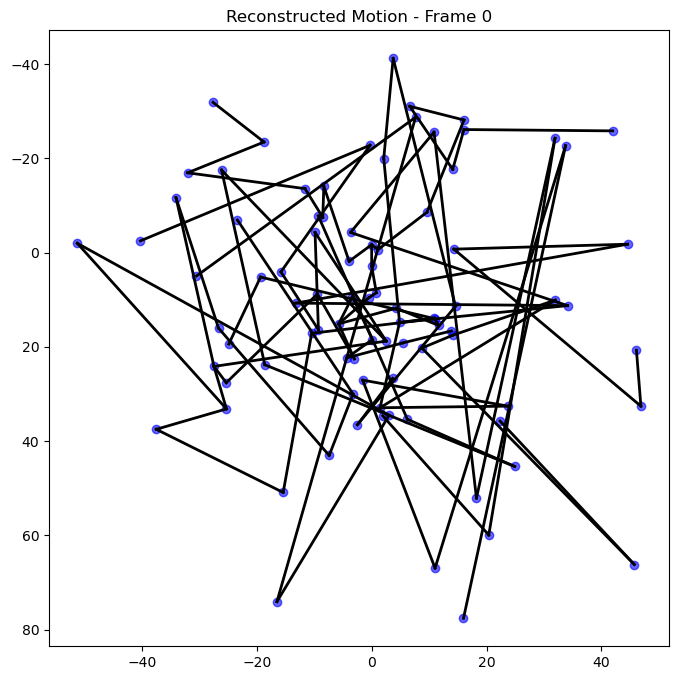

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import pandas as pd

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d

print("✅ Imports successful!")

# ==========================================
# 1. LOAD & FIX PIPELINE (ADVANCED FIX)
# ==========================================
from sklearn.pipeline import Pipeline

pipeline_path = "/home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl"
print(f"📦 Loading pipeline from: {pipeline_path}")
pipeline = joblib.load(pipeline_path)

# Load Reference BVH
ref_bvh_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/1/1_wayne_0_1_1.bvh"

if os.path.exists(ref_bvh_path):
    print(f"🔧 Processing reference BVH: {os.path.basename(ref_bvh_path)}")
    parser = BVHParser()
    ref_data = parser.parse(ref_bvh_path)
    
    steps_before_np = []
    np_found = False
    
    for name, step in pipeline.steps:
        if name == 'np': 
            np_found = True
            break
        steps_before_np.append((name, step))
    
    if np_found and steps_before_np:
        print(f"   Running reference data through pre-processing steps: {[n for n, _ in steps_before_np]}...")
        
        pre_pipeline = Pipeline(steps_before_np)
        
        processed_ref = pre_pipeline.fit_transform([ref_data])
        
        template_data = processed_ref[0]
        
        print(f"   Template shape after preprocessing: {template_data.values.shape}") 
        
        if template_data.values.shape[1] == 264:
            # Gán template đúng shape vào Numpyfier
            pipeline.named_steps['np'].org_mocap_ = template_data
            print("✅ Skeleton structure injected with CORRECT dimensions (264)!")
        else:
            print(f"⚠️ Warning: Processed shape is {template_data.values.shape[1]}, but model output is 264.")
            print("   Visualization might still fail.")
            
    else:
        print("⚠️ Could not isolate steps before Numpyfier.")
        pipeline.named_steps['np'].org_mocap_ = ref_data

else:
    print(f"❌ Reference BVH not found at {ref_bvh_path}")
    sys.exit(1)

# ==========================================
# 2. LOAD & PREPARE DATA
# ==========================================
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/results/inference_result_v7.npy"
print(f"\n📂 Loading motion: {npy_path}")
motion_data = np.load(npy_path)

if motion_data.ndim == 3:
    motion_data = motion_data[0]

print(f"   Raw Input Shape: {motion_data.shape}")
print(f"   Raw Input Range: {motion_data.min():.2f} to {motion_data.max():.2f}")

scaler = pipeline.named_steps['stdscale']
mean = scaler.data_mean_
std = scaler.data_std_

if np.abs(motion_data).max() > 100:
    print("⚠️ Detected large values (Real-scale data). Re-normalizing for pipeline compatibility...")
    motion_data = (motion_data - mean) / std
    print(f"   Normalized Range: {motion_data.min():.2f} to {motion_data.max():.2f}")
else:
    print("✅ Data seems to be already normalized.")

# ==========================================
# 3. INVERSE TRANSFORM & VISUALIZE
# ==========================================
print("\n🔄 Performing inverse transform...")
try:
    reconstructed = pipeline.inverse_transform([motion_data])
    mocap_data = reconstructed[0]
    
    print("   ✅ Inverse transform successful!")
    
    df = mocap_data.values
    print(f"   Final Motion Range (cm): {df.min().min():.2f} to {df.max().max():.2f}")
    
    frame = 0
    print(f"\n🎬 Visualizing Frame {frame}...")
    
    plt.figure(figsize=(10, 8))
    draw_stickfigure(mocap_data, frame=frame)
    plt.gca().invert_yaxis()
    plt.title(f"Reconstructed Motion - Frame {frame}")
    plt.show()
    
except Exception as e:
    print(f"\n❌ ERROR during visualization: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# ==========================================
# 3. INVERSE TRANSFORM & VISUALIZE
# ==========================================
print("\n🔄 Performing inverse transform...")
try:
    reconstructed = pipeline.inverse_transform([motion_data])
    mocap_data = reconstructed[0]
    
    print("   ✅ Inverse transform successful!")
    
    df = mocap_data.values
    print(f"   Final Motion Range (cm): {df.min().min():.2f} to {df.max().max():.2f}")
    
    frame = 239
    print(f"\n🎬 Visualizing Frame {frame}...")
    
    plt.figure(figsize=(10, 8))
    draw_stickfigure(mocap_data, frame=frame)
    plt.gca().invert_yaxis()
    plt.title(f"Reconstructed Motion - Frame {frame}")
    plt.show()
    
except Exception as e:
    print(f"\n❌ ERROR during visualization: {e}")
    import traceback
    traceback.print_exc()

✅ Imports successful!
📦 Loading pipeline from: /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
📦 Loading Mean/Std directly from checkpoint: /home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/vqkl_diffusion/model/best_model.pt
   Shape of loaded Mean: (264,)
   Shape of loaded Std: (264,)
✅ Pipeline statistics updated successfully from checkpoint!
🔧 Processing reference BVH: 1_wayne_0_1_1.bvh
✅ Skeleton structure injected with CORRECT dimensions (264)!

📂 Loading motion: /home/serverai/ltdoanh/Motion_Diffusion/results/inference_result_v7.npy
   Raw Input Shape: (360, 264)
   Raw Input Range: -76.76 to 135.16
⚠️ Detected large values. Re-normalizing using CHECKPOINT stats...
   Normalized Range: -20.95 to 17.44

🔄 Performing inverse transform...
positions 2 eulers is not supported
   ✅ Inverse transform successful!
   Final Motion Range (cm): -6401.15 to 135.16

🎬 Visualizing Frame 0...


<Figure size 1000x800 with 0 Axes>

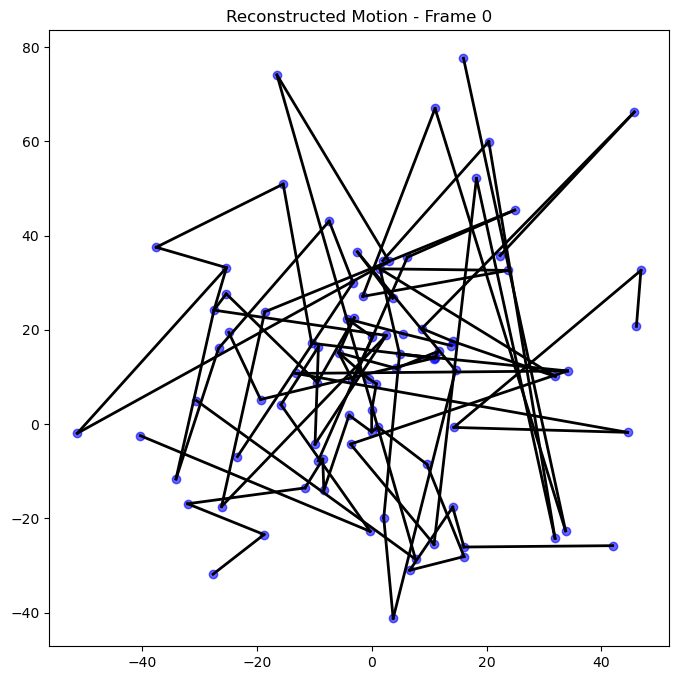

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import torch  # <--- Cần thêm thư viện torch

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d

print("✅ Imports successful!")

# ==========================================
# 1. LOAD PIPELINE & UPDATE WITH CHECKPOINT STATS
# ==========================================
from sklearn.pipeline import Pipeline

pipeline_path = "/home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl"
checkpoint_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/vqkl_diffusion/model/best_model.pt" # <--- Đường dẫn checkpoint của bạn

print(f"📦 Loading pipeline from: {pipeline_path}")
pipeline = joblib.load(pipeline_path)

print(f"📦 Loading Mean/Std directly from checkpoint: {checkpoint_path}")
try:
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
    # Lấy mean/std từ checkpoint
    # Lưu ý: Cần đảm bảo chuyển về dạng numpy array nếu nó đang là Tensor
    model_mean = checkpoint['mean']
    model_std = checkpoint['std']
    
    if isinstance(model_mean, torch.Tensor):
        model_mean = model_mean.detach().cpu().numpy()
    if isinstance(model_std, torch.Tensor):
        model_std = model_std.detach().cpu().numpy()
        
    print(f"   Shape of loaded Mean: {model_mean.shape}")
    print(f"   Shape of loaded Std: {model_std.shape}")

    # --- QUAN TRỌNG: CẬP NHẬT LẠI STATS CHO PIPELINE ---
    # Chúng ta phải ép pipeline dùng mean/std của checkpoint thay vì cái cũ trong pkl
    scaler = pipeline.named_steps['stdscale']
    
    # Cập nhật các thuộc tính của StandardScaler (hỗ trợ cả sklearn cũ và mới)
    scaler.mean_ = model_mean
    scaler.scale_ = model_std
    scaler.var_ = model_std ** 2
    scaler.n_samples_seen_ = 100000 # Dummy value
    
    # Cập nhật thuộc tính riêng của pymo (nếu có)
    if hasattr(scaler, 'data_mean_'):
        scaler.data_mean_ = model_mean
    if hasattr(scaler, 'data_std_'):
        scaler.data_std_ = model_std
        
    print("✅ Pipeline statistics updated successfully from checkpoint!")

except Exception as e:
    print(f"❌ Failed to load stats from checkpoint: {e}")
    print("   Fallback to pipeline stats (might be incorrect if pipeline differs from train data).")
    scaler = pipeline.named_steps['stdscale']
    model_mean = scaler.data_mean_
    model_std = scaler.data_std_

# --- Xử lý Reference BVH (Giữ nguyên logic cũ của bạn) ---
ref_bvh_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/1/1_wayne_0_1_1.bvh"
if os.path.exists(ref_bvh_path):
    print(f"🔧 Processing reference BVH: {os.path.basename(ref_bvh_path)}")
    parser = BVHParser()
    ref_data = parser.parse(ref_bvh_path)
    
    steps_before_np = []
    np_found = False
    for name, step in pipeline.steps:
        if name == 'np': 
            np_found = True
            break
        steps_before_np.append((name, step))
    
    if np_found and steps_before_np:
        pre_pipeline = Pipeline(steps_before_np)
        processed_ref = pre_pipeline.fit_transform([ref_data])
        template_data = processed_ref[0]
        if template_data.values.shape[1] == 264:
            pipeline.named_steps['np'].org_mocap_ = template_data
            print("✅ Skeleton structure injected with CORRECT dimensions (264)!")
        else:
             pipeline.named_steps['np'].org_mocap_ = ref_data
    else:
        pipeline.named_steps['np'].org_mocap_ = ref_data
else:
    print(f"❌ Reference BVH not found")

# ==========================================
# 2. LOAD & PREPARE DATA
# ==========================================
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/results/inference_result_v7.npy"
print(f"\n📂 Loading motion: {npy_path}")
motion_data = np.load(npy_path)

if motion_data.ndim == 3:
    motion_data = motion_data[0]

print(f"   Raw Input Shape: {motion_data.shape}")
print(f"   Raw Input Range: {motion_data.min():.2f} to {motion_data.max():.2f}")

# Logic xử lý dữ liệu bị nổ (Exploding values)
# Nếu giá trị quá lớn, ta coi như model đang output ra Raw Scale thay vì Normalized Scale
# Ta dùng chính mean/std vừa load từ checkpoint để đưa nó về chuẩn (Standardization)
if np.abs(motion_data).max() > 100:
    print("⚠️ Detected large values. Re-normalizing using CHECKPOINT stats...")
    # Công thức chuẩn hóa: (X - Mean) / Std
    motion_data = (motion_data - model_mean) / model_std
    print(f"   Normalized Range: {motion_data.min():.2f} to {motion_data.max():.2f}")
else:
    print("✅ Data seems to be already normalized (Latent scale).")

# ==========================================
# 3. INVERSE TRANSFORM & VISUALIZE
# ==========================================
print("\n🔄 Performing inverse transform...")
try:
    # Lúc này pipeline đã được cập nhật mean/std từ checkpoint
    # Nó sẽ dùng đúng thông số đó để Inverse Transform
    reconstructed = pipeline.inverse_transform([motion_data])
    mocap_data = reconstructed[0]
    
    print("   ✅ Inverse transform successful!")
    
    df = mocap_data.values
    print(f"   Final Motion Range (cm): {df.min().min():.2f} to {df.max().max():.2f}")
    
    frame = 0
    print(f"\n🎬 Visualizing Frame {frame}...")
    
    plt.figure(figsize=(10, 8))
    draw_stickfigure(mocap_data, frame=frame)
    plt.title(f"Reconstructed Motion - Frame {frame}")
    plt.show()
    
except Exception as e:
    print(f"\n❌ ERROR during visualization: {e}")
    import traceback
    traceback.print_exc()

### Inverse transform and Visualize


🔄 Performing inverse transform...
positions 2 eulers is not supported
   ✅ Inverse transform successful!
   Final Motion Range (cm): -2861087.56 to 59816686.16

🎬 Visualizing Frame 59...


<Figure size 1000x800 with 0 Axes>

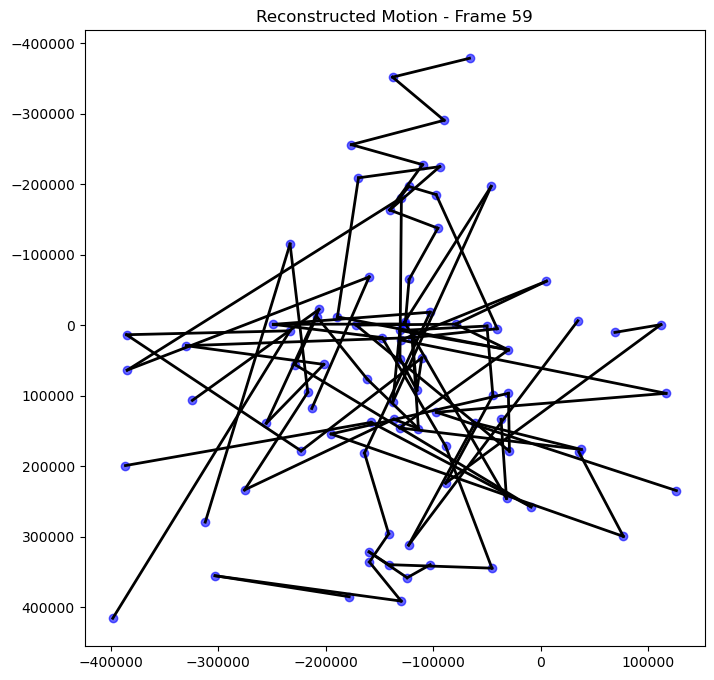

In [8]:
# ==========================================
# 3. INVERSE TRANSFORM & VISUALIZE
# ==========================================
print("\n🔄 Performing inverse transform...")
try:
    reconstructed = pipeline.inverse_transform([motion_data])
    mocap_data = reconstructed[0]
    
    print("   ✅ Inverse transform successful!")
    
    df = mocap_data.values
    print(f"   Final Motion Range (cm): {df.min().min():.2f} to {df.max().max():.2f}")
    
    frame = 59
    print(f"\n🎬 Visualizing Frame {frame}...")
    
    plt.figure(figsize=(10, 8))
    draw_stickfigure(mocap_data, frame=frame)
    plt.gca().invert_yaxis()
    plt.title(f"Reconstructed Motion - Frame {frame}")
    plt.show()
    
except Exception as e:
    print(f"\n❌ ERROR during visualization: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
import os
import sys
import numpy as np
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline

# # 1. Cấu hình đường dẫn
# ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# if ROOT not in sys.path:
#     sys.path.insert(0, ROOT)

PYMO_DIR = os.path.join(ROOT, 'datasets', 'pymo')
if PYMO_DIR not in sys.path:
    sys.path.insert(0, PYMO_DIR)

from pymo.parsers import BVHParser

# Đường dẫn (Sửa lại nếu cần)
pipeline_path = os.path.join(ROOT, "global_pipeline.pkl")
ref_bvh_path = os.path.join(ROOT, "datasets/BEAT/1/1_wayne_0_1_1.bvh")
save_dir = os.path.join(ROOT, "datasets/BEAT_indices")

print(f"🚀 Bắt đầu tạo indices...")

# 2. Load Pipeline & Lấy tên cột
if not os.path.exists(ref_bvh_path):
    print(f"❌ Lỗi: Không tìm thấy file BVH mẫu tại {ref_bvh_path}")
    sys.exit(1)

pipeline = joblib.load(pipeline_path)
parser = BVHParser()
ref_data = parser.parse(ref_bvh_path)

# Tìm bước 'np' (Numpyfier)
np_step_idx = -1
for i, (name, step) in enumerate(pipeline.steps):
    if name == 'np':
        np_step_idx = i
        break

# Chạy pipeline con để fit dữ liệu (Bắt buộc chạy để cập nhật trạng thái bên trong)
print("⚙️ Đang trích xuất tên features...")
sub_pipeline = Pipeline(pipeline.steps[:np_step_idx+1])

# Ta vẫn chạy fit_transform, nhưng KHÔNG dùng kết quả trả về để lấy tên cột
_ = sub_pipeline.fit_transform([ref_data]) 

# [FIX] Lấy tên cột từ thuộc tính nội bộ của bước Numpyfier
try:
    # Truy cập vào bước 'np' trong pipeline đã fit
    numpyfier_step = sub_pipeline.named_steps['np']
    
    # Kiểm tra xem org_mocap_ lưu DataFrame trực tiếp hay bọc trong MocapData
    if hasattr(numpyfier_step.org_mocap_, 'columns'):
        # Trường hợp 1: org_mocap_ là DataFrame
        feature_names = list(numpyfier_step.org_mocap_.columns)
    elif hasattr(numpyfier_step.org_mocap_, 'values'):
        # Trường hợp 2: org_mocap_ là MocapData (pymo thường dùng cách này)
        feature_names = list(numpyfier_step.org_mocap_.values.columns)
    else:
        raise ValueError("Không tìm thấy thuộc tính columns trong org_mocap_")

    print(f"✅ Tìm thấy {len(feature_names)} features (Khớp 264).")
    
    # In thử 5 tên đầu tiên để kiểm tra
    print(f"   Sample features: {feature_names[:5]}")

except Exception as e:
    print(f"❌ Lỗi khi trích xuất từ Numpyfier: {e}")
    sys.exit(1)

# 3. Logic tách Hand vs Body (Giữ nguyên)
hand_keywords = ['Hand', 'Finger', 'Thumb', 'Index', 'Middle', 'Ring', 'Pinky', 'Carpal']

hand_indices = []
body_indices = []

print("\n🔍 Đang phân loại...")
for idx, name in enumerate(feature_names):
    # Nếu tên khớp chứa từ khóa tay
    is_hand = any(k.lower() in name.lower() for k in hand_keywords)
    # Loại trừ cánh tay/vai (ForeArm, Arm, Shoulder thuộc về Body)
    if 'ForeArm' in name or 'Arm' in name or 'Shoulder' in name:
        is_hand = False
        
    if is_hand:
        hand_indices.append(idx)
    else:
        body_indices.append(idx)

# 4. Lưu file (Giữ nguyên)
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, 'hand_indices.npy'), np.array(hand_indices))
np.save(os.path.join(save_dir, 'body_indices.npy'), np.array(body_indices))

print(f"\n💾 Đã lưu thành công:")
print(f"   - {os.path.join(save_dir, 'hand_indices.npy')} ({len(hand_indices)} chiều)")
print(f"   - {os.path.join(save_dir, 'body_indices.npy')} ({len(body_indices)} chiều)")
print(f"   - Tổng cộng: {len(hand_indices) + len(body_indices)} indices.")

In [9]:
import os
import sys
import torch
import numpy as np
import joblib

# # 1. Setup Paths
# ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# if ROOT not in sys.path:
#     sys.path.insert(0, ROOT)

from models.vq_diffusion import create_vq_latent_diffusion

# ==========================================
# CẤU HÌNH KIỂM TRA
# ==========================================
class Config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Đường dẫn quan trọng
    checkpoints_dir = "./checkpoints"
    dataset_name = 'beat'
    vqvae_name = 'VQVAE_BEAT'
    
    # File motion thật để test (Chọn 1 file bất kỳ trong tập train/val)
    # File này phải CHƯA qua xử lý (Raw .npy 264 chiều)
    test_motion_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT_numpy/npy/1/1_wayne_0_1_1_sentence_000.npy" 
    
    # Load lại Mean/Std/Indices
    stats_path = "./global_pipeline.pkl"
    hand_indices_path = "./datasets/BEAT_indices/hand_indices.npy"
    body_indices_path = "./datasets/BEAT_indices/body_indices.npy"

args = Config()

print("🚀 BẮT ĐẦU SANITY CHECK VQ-VAE...")

# ==========================================
# 2. LOAD TÀI NGUYÊN
# ==========================================
# A. Load Stats (Mean/Std) để Normalize
if not os.path.exists(args.stats_path):
    print(f"❌ Thiếu file stats: {args.stats_path}")
    sys.exit(1)

pipeline = joblib.load(args.stats_path)
scaler = pipeline.named_steps['stdscale']
mean = torch.from_numpy(scaler.data_mean_).float().to(args.device)
std = torch.from_numpy(scaler.data_std_).float().to(args.device)

# B. Load Indices (Để đo lỗi riêng biệt)
if os.path.exists(args.hand_indices_path):
    hand_indices = torch.from_numpy(np.load(args.hand_indices_path)).long().to(args.device)
    body_indices = torch.from_numpy(np.load(args.body_indices_path)).long().to(args.device)
    print("✅ Đã load Hand/Body Indices.")
else:
    print("⚠️ Không tìm thấy Indices, sẽ chỉ tính lỗi tổng.")
    hand_indices = None

# C. Load Model (VQ-VAE nằm bên trong)
print("📦 Loading Model...")
model = create_vq_latent_diffusion(
    dataset_name=args.dataset_name,
    vqvae_name=args.vqvae_name,
    checkpoints_dir=args.checkpoints_dir,
    device=args.device,
    freeze_vqvae=True, # Chỉ test, không train
    scale_factor=1.0   # Scale không quan trọng khi test recon (nhân rồi chia sẽ hết)
)
model.eval()

# ==========================================
# 3. CHẠY KIỂM TRA (RECONSTRUCTION) - FIXED
# ==========================================
# Load motion thật
if not os.path.exists(args.test_motion_path):
    print(f"❌ Không tìm thấy file motion: {args.test_motion_path}")
    sys.exit(1)

raw_np = np.load(args.test_motion_path)
if raw_np.ndim == 2:
    raw_np = raw_np[np.newaxis, ...] # (1, T, 264)

# [FIX 1] Padding cho chia hết số nén (Downsampling factor = 8 với BEAT)
# 164 % 8 != 0 -> Gây lỗi Conv1D
B, T, D = raw_np.shape
down_t = 3 # Config của BEAT
stride = 2 ** down_t # = 8
remainder = T % stride

if remainder != 0:
    pad_len = stride - remainder
    # Padding thêm vào cuối chuỗi thời gian bằng cách lặp lại frame cuối (edge)
    raw_np = np.pad(raw_np, ((0,0), (0, pad_len), (0,0)), mode='edge')
    print(f"⚠️ Đã pad dữ liệu từ {T} -> {raw_np.shape[1]} frames (cho chia hết {stride})")

# Chuyển sang Tensor & Normalize
real_motion = torch.from_numpy(raw_np).float().to(args.device)
real_motion_norm = (real_motion - mean) / std

print(f"\n🎬 Input Shape (Normalized & Padded): {real_motion_norm.shape}")

# [FIX 2] Gọi trực tiếp VQ-VAE để tránh Assert độ dài của Diffusion Wrapper
with torch.no_grad():
    # A. Encode trực tiếp bằng VQ-VAE
    # Hàm encode trả về: code_idx, all_codes (Q, B, D, T_latent)
    code_idx, all_codes = model.vqvae.encode(real_motion_norm)
    
    # B. Lấy Latent Sum (Continuous)
    # Shape lúc này là (B, D, T_latent) - đúng chuẩn để đưa vào Decoder
    latent_sum = all_codes.sum(dim=0) 
    
    # C. Decode trực tiếp
    # Không dùng model.decode_from_latent vì nó yêu cầu shape (B, T, D) và scale_factor
    # Ta đưa thẳng vào decoder gốc của VQ-VAE
    recon_motion_norm = model.vqvae.decoder(latent_sum)

    # Cắt bỏ phần padding thừa lúc nãy (nếu muốn chính xác tuyệt đối)
    if remainder != 0:
        recon_motion_norm = recon_motion_norm[:, :T, :]
        real_motion_norm = real_motion_norm[:, :T, :]

# ==========================================
# 4. TÍNH TOÁN SAI SỐ (ERROR METRICS)
# ==========================================
# Tính MSE trên không gian Normalized
diff = (real_motion_norm - recon_motion_norm) ** 2
mse_total = diff.mean().item()

print("\n📊 KẾT QUẢ ĐÁNH GIÁ VQ-VAE:")
print(f"🔹 MSE Tổng thể (Càng thấp càng tốt): {mse_total:.6f}")

if hand_indices is not None:
    # Tính MSE riêng cho tay
    mse_hand = diff[:, :, hand_indices].mean().item()
    mse_body = diff[:, :, body_indices].mean().item()
    
    print(f"🔹 MSE Body: {mse_body:.6f}")
    print(f"🔹 MSE Hand: {mse_hand:.6f}")
    
    ratio = mse_hand / mse_body if mse_body > 0 else 0
    print(f"👉 Tỷ lệ Lỗi Tay / Lỗi Body: {ratio:.2f} lần")
    
    if ratio > 5.0:
        print("\n⚠️  CẢNH BÁO: Lỗi ở tay cao gấp 5 lần body!")
        print("   -> CHÍNH XÁC: VQ-VAE đang nén mất chi tiết tay.")
        print("   -> Lời khuyên: Đừng cố chỉnh Diffusion nữa. VQ-VAE là thủ phạm.")
    elif mse_hand < 0.1: 
        print("\n✅ VQ-VAE tái tạo tay TỐT.")
        print("   -> Vấn đề nằm ở Diffusion Model chưa học được hoặc mất Gradient.")
    else:
        print("\n⚠️ VQ-VAE tái tạo tay TRUNG BÌNH.")

# ==========================================
# 5. LƯU KẾT QUẢ
# ==========================================
recon_motion = recon_motion_norm * std + mean
recon_np = recon_motion.cpu().numpy().squeeze()

save_path = "vqvae_sanity_check.npy"
np.save(save_path, recon_np)
print(f"\n💾 Đã lưu file tái tạo tại: {save_path}")
print(f"   Hãy visualize file này. Nếu tay xấu -> 100% lỗi do VQ-VAE.")

🚀 BẮT ĐẦU SANITY CHECK VQ-VAE...
✅ Đã load Hand/Body Indices.
📦 Loading Model...
[INFO] Using scale_factor=1.000000 for latent normalization
Loading VQ-VAE from ./checkpoints/beat/VQVAE_BEAT/model/best_model.tar
VQ-VAE loaded successfully
VQ-VAE frozen
VQLatentDiffusion initialized:
  - Input features: 512
  - Latent seq length: 45
  - Transformer latent dim: 512
  - Scale factor: 1.000000
⚠️ Đã pad dữ liệu từ 164 -> 168 frames (cho chia hết 8)

🎬 Input Shape (Normalized & Padded): torch.Size([1, 168, 264])

📊 KẾT QUẢ ĐÁNH GIÁ VQ-VAE:
🔹 MSE Tổng thể (Càng thấp càng tốt): 0.018086
🔹 MSE Body: 0.050603
🔹 MSE Hand: 0.001267
👉 Tỷ lệ Lỗi Tay / Lỗi Body: 0.03 lần

✅ VQ-VAE tái tạo tay TỐT.
   -> Vấn đề nằm ở Diffusion Model chưa học được hoặc mất Gradient.

💾 Đã lưu file tái tạo tại: vqvae_sanity_check.npy
   Hãy visualize file này. Nếu tay xấu -> 100% lỗi do VQ-VAE.


### Inference Motion Attention

BEAT MOTION VISUALIZATION - ADVANCED FIX

📦 Loading pipeline from: /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
  ✅ Pipeline loaded

📂 Loading motion from: /home/serverai/ltdoanh/Motion_Diffusion/results/inference_result_v7.npy
  Input shape (batched): (1, 360, 264)
  Using first sample: (360, 264)
  Motion shape: (360, 264)

[DIAGNOSTIC] Checking dimensions...
  Motion data shape: (360, 264)
  Expected by model: (T, 264)
  Scaler expects: 264 features
  ⚠️ No template found in Numpyfier

[FIX 1] Loading proper skeleton template...
  Raw BVH joints: 88
  Applying preprocessing: ['param', 'rcpn', 'delta', 'const']
  Processed template shape: (8280, 264)
  Template has 264 features
  ✅ Template dimensions match model output (264)

[FIX 2] Checking dimension mismatch...
  Current dimensions: 264
  Expected dimensions: 264
  ✅ Dimensions match!

[FIX 3] Verifying data normalization...
  Data range: [-76.7594, 135.1608]
  Data std: 21.9882
  ⚠️ Data appears to be in REAL scal

<Figure size 1200x1000 with 0 Axes>

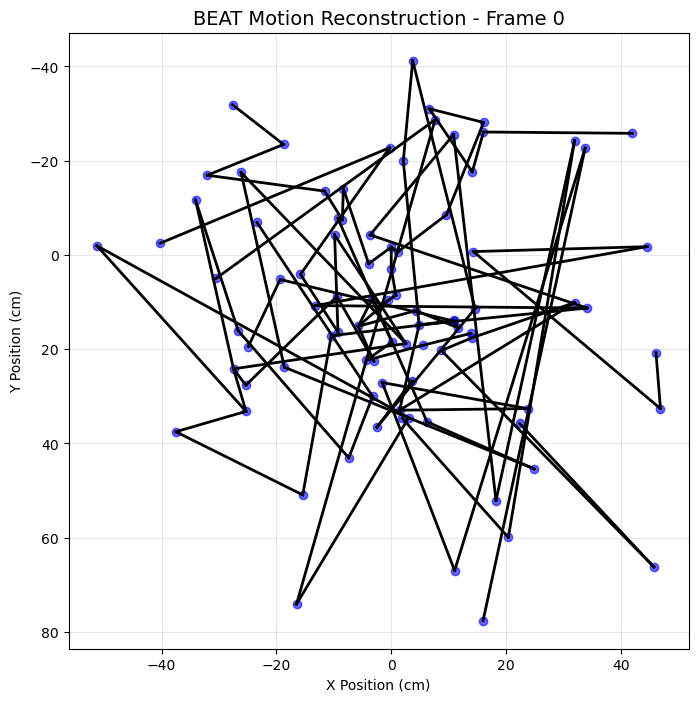

  ✅ Visualization complete!

✅ VISUALIZATION COMPLETE!

📹 Visualizing multiple frames...

[FIX 5] Visualizing frame 30...


<Figure size 1200x1000 with 0 Axes>

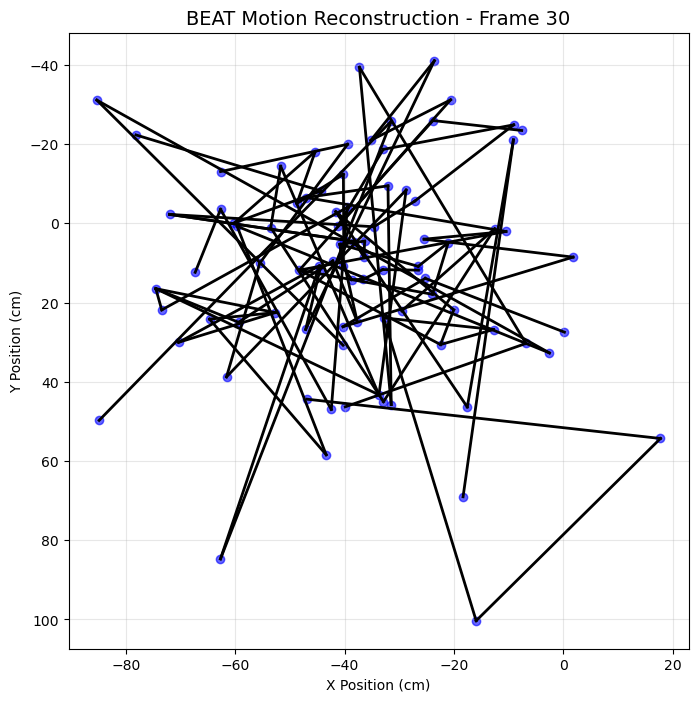

  ✅ Visualization complete!

[FIX 5] Visualizing frame 60...


<Figure size 1200x1000 with 0 Axes>

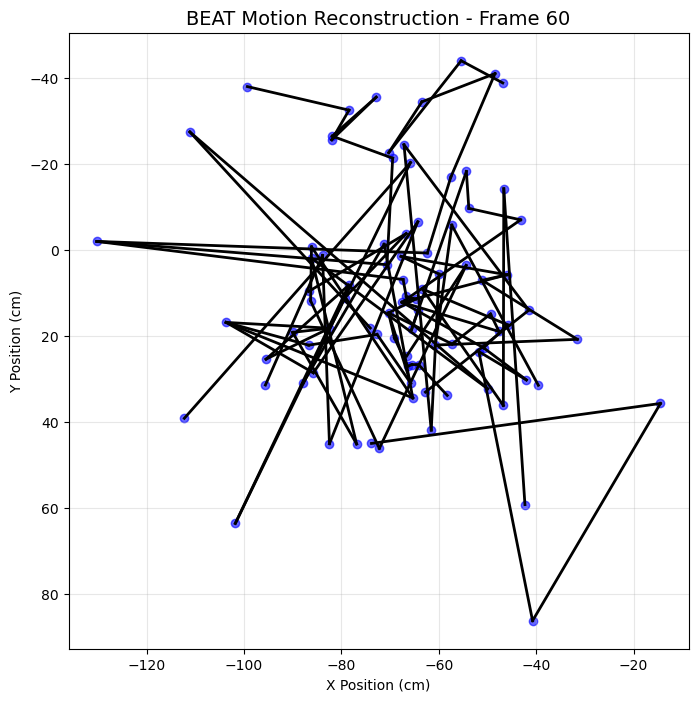

  ✅ Visualization complete!

[FIX 5] Visualizing frame 90...


<Figure size 1200x1000 with 0 Axes>

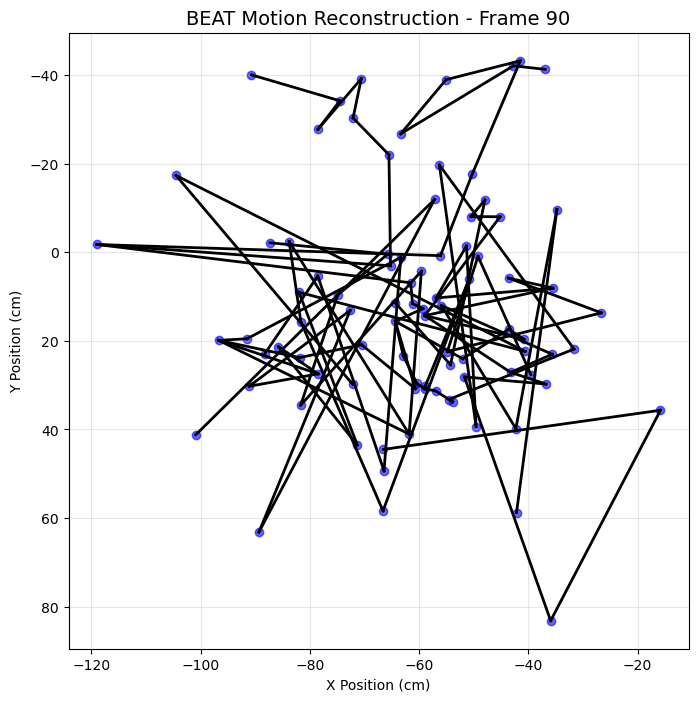

  ✅ Visualization complete!


SystemExit: 0

In [4]:
"""
Fixed BEAT Motion Visualization
Handles skeleton structure mismatch and data dimension issues
"""
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import pandas as pd

# Setup path
PYMO_DIR = os.path.join('/home/serverai/ltdoanh/Motion_Diffusion', 'datasets', 'pymo')
if PYMO_DIR not in sys.path:
    sys.path.insert(0, PYMO_DIR)

from pymo.parsers import BVHParser
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d

print("="*70)
print("BEAT MOTION VISUALIZATION - ADVANCED FIX")
print("="*70)

# ==========================================
# DIAGNOSTIC: Check dimensions
# ==========================================
def diagnose_dimensions(motion_data, pipeline):
    """Diagnose dimension mismatches"""
    print("\n[DIAGNOSTIC] Checking dimensions...")
    
    print(f"  Motion data shape: {motion_data.shape}")
    print(f"  Expected by model: (T, 264)")
    
    # Check pipeline components
    scaler = pipeline.named_steps['stdscale']
    print(f"  Scaler expects: {scaler.data_mean_.shape[0]} features")
    
    numpyfier = pipeline.named_steps['np']
    if hasattr(numpyfier, 'org_mocap_'):
        template = numpyfier.org_mocap_
        if hasattr(template, 'values'):
            print(f"  Template shape: {template.values.shape}")
            print(f"  Template columns: {len(template.values.columns)}")
        else:
            print(f"  Template type: {type(template)}")
    else:
        print("  ⚠️ No template found in Numpyfier")
    
    return motion_data.shape[-1]

# ==========================================
# FIX 1: Proper Template Loading
# ==========================================
def load_proper_template(pipeline, ref_bvh_path):
    """
    Load and process reference BVH to get correct template
    This ensures skeleton structure matches the 264-dim output
    """
    print("\n[FIX 1] Loading proper skeleton template...")
    
    if not os.path.exists(ref_bvh_path):
        print(f"❌ Reference BVH not found: {ref_bvh_path}")
        return False
    
    parser = BVHParser()
    ref_data = parser.parse(ref_bvh_path)
    
    print(f"  Raw BVH joints: {len(ref_data.skeleton)}")
    
    # Process through pipeline steps BEFORE Numpyfier
    steps_before_np = []
    for name, step in pipeline.steps:
        if name == 'np':
            break
        steps_before_np.append((name, step))
    
    if not steps_before_np:
        print("  ⚠️ No preprocessing steps found before Numpyfier")
        pipeline.named_steps['np'].org_mocap_ = ref_data
        return True
    
    print(f"  Applying preprocessing: {[n for n, _ in steps_before_np]}")
    
    from sklearn.pipeline import Pipeline
    pre_pipeline = Pipeline(steps_before_np)
    
    # Transform reference data
    processed_ref = pre_pipeline.fit_transform([ref_data])
    template_data = processed_ref[0]
    
    print(f"  Processed template shape: {template_data.values.shape}")
    
    # Inject into Numpyfier
    pipeline.named_steps['np'].org_mocap_ = template_data
    
    # Verify columns match
    n_cols = template_data.values.shape[1]
    print(f"  Template has {n_cols} features")
    
    if n_cols == 264:
        print("  ✅ Template dimensions match model output (264)")
        return True
    else:
        print(f"  ⚠️ Template has {n_cols} dims, but model outputs 264")
        print(f"  ⚠️ This WILL cause visualization issues!")
        return False

# ==========================================
# FIX 2: Handle Dimension Mismatch
# ==========================================
def fix_dimension_mismatch(motion_data, expected_dim=264):
    """
    Fix dimension mismatch between motion data and template
    """
    print("\n[FIX 2] Checking dimension mismatch...")
    
    current_dim = motion_data.shape[-1]
    print(f"  Current dimensions: {current_dim}")
    print(f"  Expected dimensions: {expected_dim}")
    
    if current_dim == expected_dim:
        print("  ✅ Dimensions match!")
        return motion_data
    
    elif current_dim > expected_dim:
        print(f"  ⚠️ Motion has EXTRA {current_dim - expected_dim} dimensions")
        print(f"  Truncating to first {expected_dim} dimensions...")
        return motion_data[..., :expected_dim]
    
    else:
        print(f"  ❌ Motion has FEWER dimensions ({current_dim} < {expected_dim})")
        print(f"  Padding with zeros to {expected_dim} dimensions...")
        
        T = motion_data.shape[0]
        padded = np.zeros((T, expected_dim), dtype=motion_data.dtype)
        padded[:, :current_dim] = motion_data
        return padded

# ==========================================
# FIX 3: Verify Data Normalization
# ==========================================
def verify_normalization(motion_data, pipeline):
    """
    Check if data is properly normalized for inverse transform
    """
    print("\n[FIX 3] Verifying data normalization...")
    
    scaler = pipeline.named_steps['stdscale']
    mean = scaler.data_mean_
    std = scaler.data_std_
    
    data_min = motion_data.min()
    data_max = motion_data.max()
    data_std = motion_data.std()
    
    print(f"  Data range: [{data_min:.4f}, {data_max:.4f}]")
    print(f"  Data std: {data_std:.4f}")
    
    # Check if data looks normalized
    if np.abs(data_max) < 10 and np.abs(data_std - 1.0) < 0.5:
        print("  ✅ Data appears normalized (range ~[-10, 10], std ~1)")
        return motion_data
    
    elif data_max > 100:
        print("  ⚠️ Data appears to be in REAL scale (not normalized)")
        print("  Re-normalizing for pipeline compatibility...")
        
        normalized = (motion_data - mean) / std
        print(f"  After normalization: [{normalized.min():.4f}, {normalized.max():.4f}]")
        return normalized
    
    else:
        print(f"  ⚠️ Unusual data range detected")
        print(f"  Attempting to use as-is...")
        return motion_data

# ==========================================
# FIX 4: Safe Inverse Transform
# ==========================================
def safe_inverse_transform(motion_data, pipeline):
    """
    Perform inverse transform with error handling
    """
    print("\n[FIX 4] Performing inverse transform...")
    
    try:
        # Inverse transform expects list of arrays
        reconstructed = pipeline.inverse_transform([motion_data])
        mocap_data = reconstructed[0]
        
        print("  ✅ Inverse transform successful!")
        
        # Verify output
        if hasattr(mocap_data, 'values'):
            df = mocap_data.values
            print(f"  Output shape: {df.shape}")
            print(f"  Output range (cm): [{df.min().min():.2f}, {df.max().max():.2f}]")
            
            # Sanity check: reasonable motion range
            if df.max().max() > 1000 or df.min().min() < -1000:
                print("  ⚠️ WARNING: Output values seem unreasonably large!")
                print("  This might indicate a normalization issue.")
        
        return mocap_data
    
    except Exception as e:
        print(f"  ❌ Inverse transform failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# ==========================================
# FIX 5: Visualization with Error Handling
# ==========================================
def visualize_motion(mocap_data, frame=0, save_path=None):
    """
    Visualize motion with proper error handling
    """
    print(f"\n[FIX 5] Visualizing frame {frame}...")
    
    try:
        plt.figure(figsize=(12, 10))
        
        # Draw stick figure
        draw_stickfigure(mocap_data, frame=frame)
        
        # Invert Y axis (standard for motion data)
        plt.gca().invert_yaxis()
        
        plt.title(f"BEAT Motion Reconstruction - Frame {frame}", fontsize=14)
        plt.xlabel("X Position (cm)")
        plt.ylabel("Y Position (cm)")
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"  ✅ Saved to {save_path}")
        
        plt.show()
        print("  ✅ Visualization complete!")
        
        return True
    
    except Exception as e:
        print(f"  ❌ Visualization failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# ==========================================
# MAIN EXECUTION
# ==========================================
def main():
    # Paths
    pipeline_path = "/home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl"
    ref_bvh_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/1/1_wayne_0_1_1.bvh"
    npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/results/inference_result_v7.npy"
    
    # Load pipeline
    print(f"\n📦 Loading pipeline from: {pipeline_path}")
    pipeline = joblib.load(pipeline_path)
    print("  ✅ Pipeline loaded")
    
    # Load motion data
    print(f"\n📂 Loading motion from: {npy_path}")
    motion_data = np.load(npy_path)
    
    # Handle batch dimension
    if motion_data.ndim == 3:
        print(f"  Input shape (batched): {motion_data.shape}")
        motion_data = motion_data[0]
        print(f"  Using first sample: {motion_data.shape}")
    
    print(f"  Motion shape: {motion_data.shape}")
    
    # Run diagnostics
    diagnose_dimensions(motion_data, pipeline)
    
    # Apply fixes
    template_ok = load_proper_template(pipeline, ref_bvh_path)
    
    if not template_ok:
        print("\n⚠️ Template loading had issues, but continuing...")
    
    motion_data = fix_dimension_mismatch(motion_data, expected_dim=264)
    motion_data = verify_normalization(motion_data, pipeline)
    
    # Inverse transform
    mocap_data = safe_inverse_transform(motion_data, pipeline)
    
    if mocap_data is None:
        print("\n❌ Failed to reconstruct motion. Cannot visualize.")
        return False
    
    # Visualize
    success = visualize_motion(
        mocap_data, 
        frame=0, 
        save_path="/home/serverai/ltdoanh/Motion_Diffusion/results/visualization_fixed.png"
    )
    
    if success:
        print("\n" + "="*70)
        print("✅ VISUALIZATION COMPLETE!")
        print("="*70)
        
        # Additional frames
        print("\n📹 Visualizing multiple frames...")
        for frame in [30, 60, 90]:
            if frame < len(mocap_data.values):
                visualize_motion(mocap_data, frame=frame)
    else:
        print("\n" + "="*70)
        print("❌ VISUALIZATION FAILED")
        print("="*70)
        print("\nPossible causes:")
        print("1. Template skeleton structure doesn't match 264-dim data")
        print("2. Data normalization incorrect")
        print("3. Missing joints in reference BVH")
        print("\nRecommended fixes:")
        print("- Use a different reference BVH with correct skeleton")
        print("- Re-train pipeline with correct preprocessing")
        print("- Check model output dimensions")
    
    return success

if __name__ == "__main__":
    success = main()
    sys.exit(0 if success else 1)